# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import algorithms.bernstein_vazirani as bv
import algorithms.qft as qft

from qiskit import QuantumCircuit, transpile, Aer
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.analysis import hellinger_fidelity

from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend

# Parameters

In [2]:
def pytket(qc: QuantumCircuit, backend):
    tk_backend = IBMQBackend(backend.name, group='uw-madison')
    tk_qc = qiskit_to_tk(qc)
    tk_backend.default_compilation_pass(2).apply(tk_qc)
    tqc = tk_to_qiskit(tk_qc)
    return tqc

def qiskit_opt_0(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=0)

def qiskit_opt_3(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3)

def qiskit_opt_3_sabre(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3, layout_method='sabre', routing_method='sabre')

In [3]:
min_qubits, max_qubits = 4, 14
algorithms = { 'Bernstein Vazirani': bv, 'QFT': qft }
techniques = { 
    'PyTket': pytket,
    'Qiskit Opt 0': qiskit_opt_0, 
    'Qiskit Opt 3': qiskit_opt_3, 
    'Qiskit Opt 3 Sabre': qiskit_opt_3_sabre 
}

In [4]:
provider = IBMProvider()
backend = provider.get_backend("ibm_oslo")

In [5]:
# from qiskit.providers.fake_provider import FakeOslo
# fake_backend = FakeOslo()
# fake_backend.name = "ibm_oslo"

# Create Transpiled Circuits

In [6]:
qcs = []
tqcs = []
cx_counts = []

for al_name, al in algorithms.items():
    for n in range(min_qubits, max_qubits+1):
        qc = al.test(n)
        qcs.append(qc)
        for t_name, t in techniques.items():
            tqc = t(qc, backend)
            tqcs.append(tqc)
            cx_counts.append(tqc.count_ops()['cx'])

# Simulate QCs

In [7]:
def simulate_classically(qc_list):
    aer_sim = Aer.get_backend('aer_simulator')
    tqc_list = transpile(qc_list, aer_sim)
    job_sim = aer_sim.run(tqc_list, shots=1000)
    results = job_sim.result()
    return results

In [8]:
sim_res_counts = simulate_classically(qcs).get_counts()
display(sim_res_counts)

[{'111': 1000},
 {'1111': 1000},
 {'11111': 1000},
 {'111111': 1000},
 {'0000': 1000},
 {'00000': 1000},
 {'000000': 1000},
 {'0000000': 1000}]

# Run on IBM QC

In [9]:
job = backend.run(tqcs, shots=1000)
# job = fake_backend.run(tqcs, shots=1000)

In [11]:
job = provider.backend.jobs()[0]
display(job.job_id())

'cfl9g112k6plbnjg42rg'

In [12]:
def calculate_avg_cx_errors(backend):
    cx_gates = [g for g in backend.properties().gates if g.gate == 'cx']
    cx_error_rate = 0
    for g in cx_gates:    
        cx_error_rate += g.parameters[0].value

    avg_cx_error_rate = cx_error_rate /len(cx_gates)
    return avg_cx_error_rate

In [13]:
avg_cx_error_rate = calculate_avg_cx_errors(backend)
print('avg_cx_error_rate: ', avg_cx_error_rate)

avg_cx_error_rate:  0.009243825744917814


In [14]:
qc_res_counts = job.result().get_counts()

# Check Fidelities

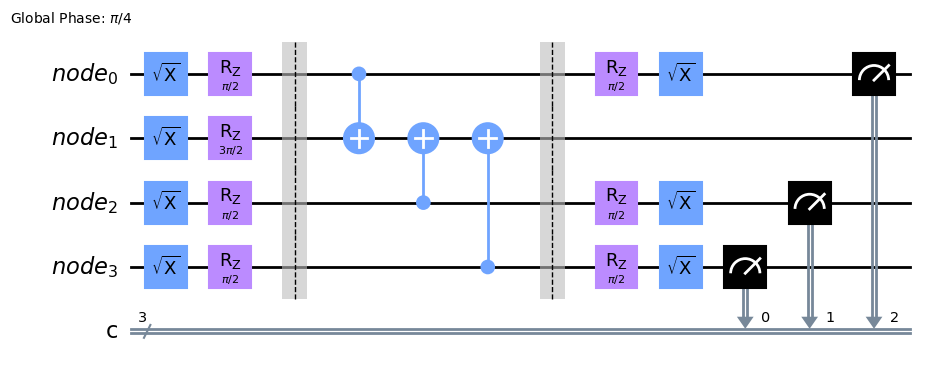

In [34]:
job.circuits()[0].draw('mpl')

In [58]:
job.time_per_step()

{'created': datetime.datetime(2023, 2, 13, 14, 5, 24, 662795, tzinfo=tzlocal()),
 'finished': datetime.datetime(2023, 2, 13, 14, 45, 32, 4488, tzinfo=tzlocal()),
 'running': datetime.datetime(2023, 2, 13, 14, 44, 1, 883633, tzinfo=tzlocal())}

In [15]:
n_s = max_qubits-min_qubits+1

for al_index, al_name in enumerate(algorithms.keys()):
    for n_index in range(n_s):
        n = n_index + min_qubits
        print('{}: n={}'.format(al_name, n))
        sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
        for t_index, t_name in enumerate(techniques.keys()):
            counts_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            qc_counts = qc_res_counts[counts_index]
            cx_count = cx_counts[counts_index]
            hf = hellinger_fidelity(sim_res_counts_n, qc_counts)
            print('{}: # cx gates: {}, fidelity={}'.format(t_name, cx_count, hf))
        print('---')
    print('------')
            

Bernstein Vazirani: n=4
PyTket: # cx gates: 3, fidelity=0.789
Qiskit Opt 0: # cx gates: 6, fidelity=0.3200000000000001
Qiskit Opt 3: # cx gates: 3, fidelity=0.789
Qiskit Opt 3 Sabre: # cx gates: 3, fidelity=0.7719999999999999
---
Bernstein Vazirani: n=5
PyTket: # cx gates: 7, fidelity=0.621
Qiskit Opt 0: # cx gates: 16, fidelity=0.10000000000000003
Qiskit Opt 3: # cx gates: 5, fidelity=0.36900000000000005
Qiskit Opt 3 Sabre: # cx gates: 7, fidelity=0.5479999999999999
---
Bernstein Vazirani: n=6
PyTket: # cx gates: 12, fidelity=0.18000000000000005
Qiskit Opt 0: # cx gates: 17, fidelity=0.09099999999999991
Qiskit Opt 3: # cx gates: 9, fidelity=0.08699999999999983
Qiskit Opt 3 Sabre: # cx gates: 9, fidelity=0.16700000000000007
---
Bernstein Vazirani: n=7
PyTket: # cx gates: 19, fidelity=0.017999999999999936
Qiskit Opt 0: # cx gates: 18, fidelity=0.031999999999999994
Qiskit Opt 3: # cx gates: 10, fidelity=0.139
Qiskit Opt 3 Sabre: # cx gates: 8, fidelity=0.06799999999999999
---
------
QFT: